In [56]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

import h5py

import torch
from CosmicNetwork import MyNet, CosmicNetwork_v2 

import camb
 

# Hyperparameters

In [57]:
# ---------------------------------------------------------------------------------------
# Planck curve of best fit --------------------------------------------------------------
# ---------------------------------------------------------------------------------------

# reduced hubble constant
h          = 0.6736
h_squared  = 0.6736**2 

T_CMB      = 2.7255
OMEGA_B0   = 0.02237
OMEGA_CDM0 = 0.1200
OMEGA_G0   = 2.471e-5
OMEGA_UR0  = 1.709e-5

l_max      = 1000
l_range    = np.arange(2, l_max+ 1)


# CAMB  and CLASS Planck parameters:
params = {
    "omega_b"   : OMEGA_B0,
    "omega_c"   : OMEGA_CDM0,
    "omega_g"   : OMEGA_G0,
    "omega_ur"  : OMEGA_UR0,
    "omega_k"   : 0.0,
    "h"         : h,
    "H0"        : 67.36,
    "YHe"       : 0.2471,
    "tau"       : 0.054,
    "As"        : 2.1e-9,
    "n_s"       : 0.965
    }

# ---------------------------------------------------------------------------------------
# Fast Fourier Transform 2d -------------------------------------------------------------
# ---------------------------------------------------------------------------------------

N_MAP     = 512

rng       = np.random.default_rng(42)
eps_fixed = (rng.normal(size=(N_MAP, N_MAP))
             + 1j * rng.normal(size=(N_MAP, N_MAP)))

# ---------------------------------------------------------------------------------------
# Torch parameters--------- -------------------------------------------------------------
# ---------------------------------------------------------------------------------------

DEVICE    = "cpu"


# Helper Functions 

In [67]:
# ---------------------------------------------------------------------------------------
# Helper functions for CMB --------------------------------------------------------------
# ---------------------------------------------------------------------------------------

def tcmb_omega_g(omega_g):
    return T_CMB * (omega_g/OMEGA_G0)**0.25

def neff_omega_ur(omega_ur, t_cmb):
    scale = (t_cmb / T_CMB)**4
    return 3.046 * omega_ur / (OMEGA_UR0 * scale)

def camb_dl(params, lmax):
    omega_b  = params["omega_b"]
    omega_c  = params["omega_c"]
    omega_g  = params["omega_g"]
    omega_ur = params["omega_ur"]
    
    t_cmb    = tcmb_omega_g(omega_g)
    Neff     = neff_omega_ur(omega_ur, t_cmb)
    
    pars     = camb.CAMBparams()
    pars.set_cosmology(H0    = params["H0"], 
                       ombh2 = omega_b,
                       omch2 = omega_c,
                       omk   = params["omega_k"],
                       YHe   = params["YHe"],
                       tau   = params["tau"],
                       TCMB  = t_cmb)

    pars.Neff = Neff    
    pars.num_massive_neutrinos   = 0
    
    pars.InitPower.set_params(As = params["As"], ns = params["n_s"])
    pars.set_accuracy(AccuracyBoost=1, lAccuracyBoost=1, lSampleBoost=1)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)

    results = camb.get_results(pars)
    Dl_camb = results.get_cmb_power_spectra(pars, CMB_unit="muK", lmax=lmax)["unlensed_scalar"][:, 0]
    return Dl_camb[2:lmax + 1]

# ---------------------------------------------------------------------------------------
# Fast Fourier Transform 2d -------------------------------------------------------------
# ---------------------------------------------------------------------------------------

def simulate_cmb_map(pow_spec, N=N_MAP, fov_deg=10.0, eps=eps_fixed, d_ell=True):
    
    fov = np.deg2rad(fov_deg)
    res = fov / N
    
    kx = np.fft.fftfreq(N, d=res)
    ky = np.fft.fftfreq(N, d=res)
    
    ell_map = 2 * np.pi * np.hypot(*np.meshgrid(kx, ky)[::-1])
    ell_map[ell_map < 2] = 2

    if d_ell:
        C_ell = 2*np.pi / (l_range * (l_range + 1))  * pow_spec
    else:
        C_ell = pow_spec
    
    Ck = np.interp(ell_map, l_range, C_ell)
    
    amp = np.sqrt(Ck**1.5 / 2.0)
    ft_map = amp * eps
    
    return np.fft.ifft2(ft_map).real

# ---------------------------------------------------------------------------------------
# Loading Model -------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------

def load_model(model_number, model_weight_path, in_dim=2, out_dim=799, lay_dim=128, hid_lay=3):

    if model_number == 1:
        model = MyNet()
        ckpt = torch.load(model_weight_path, map_location=DEVICE)
        model.load_state_dict(ckpt)
        model.eval()
    else:
        model = CosmicNetwork_v2(in_dim, out_dim, lay_dim, hid_lay)
        ckpt = torch.load(model_weight_path, map_location="cpu")
        model.load_state_dict(ckpt["model_state"])
        model.eval()
        
    return model

# ---------------------------------------------------------------------------------------
# model_helper --------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------

def get_model_input(model, omega_b=None, omega_cdm=None, omega_g=None, omega_ur=None):
    # infer input dim robustly
    try:
        first_weight = next(p for p in model.parameters() if p.ndim == 2)
        input_dim = first_weight.shape[1]
    except StopIteration:
        input_dim = getattr(model, "in_dim", 4)  # fallback

    # defaults
    omega_b   = OMEGA_B0   if omega_b   is None else omega_b
    omega_cdm = OMEGA_CDM0 if omega_cdm is None else omega_cdm
    omega_g   = OMEGA_G0   if omega_g   is None else omega_g
    omega_ur  = OMEGA_UR0  if omega_ur  is None else omega_ur

    if input_dim == 1:
        x = [omega_b]
    elif input_dim == 2:
        x = [omega_b, omega_cdm]
    elif input_dim == 4:
        x = [omega_b, omega_cdm, omega_g, omega_ur]
    else:
        raise ValueError(f"Unsupported input dimension: {input_dim}")
    return torch.tensor([x], dtype=torch.float32)

def load_pca_components(pca_path, device="cpu"):

    with h5py.File(pca_path, "r") as f:
        basis = torch.tensor(f["basis"][:], dtype=torch.float32, device=device)
        mean  = torch.tensor(f["mean_spectrum"][:], dtype=torch.float32, device=device)

    return [basis, mean]


def load_pca_components_v5(pca_path, device="cpu"):
    """Load PCA basis, mean, and explained variance for standardized coefficients."""
    with h5py.File(pca_path, "r") as f:
        basis = torch.tensor(f["basis"][:], dtype=torch.float32, device=device)
        mean  = torch.tensor(f["mean_spectrum"][:], dtype=torch.float32, device=device)
        var   = torch.tensor(f["explained_variance"][:], dtype=torch.float32, device=device)
    
    std = torch.sqrt(var)  # std of each PCA component
    return [basis, mean, std]


import numpy as np
import torch

# ─────────────────────────────────────────────────────────────
# Unified predictors
# ─────────────────────────────────────────────────────────────

def predict_log_spectrum_unified(model, x, pca):
    """
    Returns log-spectrum as torch tensor [B, L].

    pca:
      • (basis, mean)          → v4-style (model outputs PCA coeffs directly)
      • (basis, mean, std)     → v5/v7-style (model outputs STANDARDIZED PCA coeffs)
      • None                   → model outputs log-spectrum directly (no PCA)

    Notes
    -----
    - 'basis' must be [C, L], 'mean' [L], 'std' [C].
    - x must be a torch.FloatTensor on the correct device [B, in_dim].
    """
    model.eval()
    with torch.no_grad():
        if pca is None:
            # model already outputs log-spectrum
            return model(x)

        if len(pca) == 2:
            basis, mean = pca
            B = torch.as_tensor(basis, dtype=torch.float32, device=x.device)  # [C, L]
            M = torch.as_tensor(mean,  dtype=torch.float32, device=x.device)  # [L]
            return (model(x) @ B) + M

        if len(pca) == 3:
            basis, mean, std = pca
            B = torch.as_tensor(basis, dtype=torch.float32, device=x.device)  # [C, L]
            M = torch.as_tensor(mean,  dtype=torch.float32, device=x.device)  # [L]
            S = torch.as_tensor(std,   dtype=torch.float32, device=x.device)  # [C]
            coeffs_std = model(x)                                           # [B, C]
            return (coeffs_std * S) @ B + M

        raise ValueError("pca must be None, (basis, mean) or (basis, mean, std)")


def get_D_ell_unified(model,
                      l_range,
                      omega_b=None, omega_cdm=None, omega_g=None, omega_ur=None,
                      pca=None,
                      log_is_D_ell=True,
                      clamp_log=(-20.0, 20.0)):
    """
    Unified D_ell predictor that works for:
      • No PCA (model outputs log-spectrum directly)
      • v4-style PCA (basis, mean)
      • v5/v7-style PCA (basis, mean, std) with standardized coeffs

    Parameters
    ----------
    l_range : np.ndarray of ℓ (used only if log_is_D_ell == False)
    log_is_D_ell : True if the log-spectrum is log(D_ell); False if it's log(C_ell)

    Returns
    -------
    D_ell : np.ndarray [L]
    """
    # Build input
    x = get_model_input(model, omega_b, omega_cdm, omega_g, omega_ur)  # torch [1, in_dim]

    # Predict log-spectrum
    log_spec = predict_log_spectrum_unified(model, x, pca)  # [1, L]
    log_spec = torch.clamp(log_spec, clamp_log[0], clamp_log[1]).squeeze(0).cpu().numpy()

    if log_is_D_ell:
        # PCA was built from log(D_ell)  → D_ell = exp(log_spec)
        return np.exp(log_spec)
    else:
        # PCA was built from log(C_ell)  → D_ell = l(l+1)/2π * C_ell
        return (l_range * (l_range + 1)) / (2.0 * np.pi) * np.exp(log_spec)


# ─────────────────────────────────────────────────────────────
# Optional: keep your old reconstruct (works identically)
# ─────────────────────────────────────────────────────────────

def reconstruct_log_spectrum(coeffs_norm, basis, mean, std):
    """Inverse PCA: denormalize standardized coeffs and reconstruct log-spectrum."""
    coeffs = coeffs_norm * std
    return coeffs @ basis + mean


# ─────────────────────────────────────────────────────────────
# Percent error utilities
# ─────────────────────────────────────────────────────────────

def percent_error(D_true, D_pred, eps=1e-30, axis=None):
    """
    Elementwise % error: |pred - true| / true * 100.
    If axis is None → returns array of same shape as inputs.
    If axis is int/tuple → reduces along axis.
    """
    D_true = np.asarray(D_true)
    D_pred = np.asarray(D_pred)
    denom = np.clip(D_true, eps, None)
    err = np.abs(D_pred - D_true) / denom * 100.0
    if axis is None:
        return err
    return np.mean(err, axis=axis)


def percent_error_summary(D_true, D_pred, eps=1e-30):
    """
    Returns dict with {mean, median, p95, max} % errors over all ℓ (or samples × ℓ if you pass batches).
    """
    err = percent_error(D_true, D_pred, eps=eps)  # elementwise
    return {
        "mean":   float(np.mean(err)),
        "median": float(np.median(err)),
        "p95":    float(np.percentile(err, 95)),
        "max":    float(np.max(err)),
    }



def plot_d_ell(d_ell, l_range):

    plt.figure(figsize=(13, 6))  
    plt.plot(l_range, d_ell)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$D_\ell\ [\mu K^2]$")
    plt.title("Predicted $D_\\ell$ from Neural Network")
    plt.grid(True)
    plt.show()


def predict_map(model, l_range, omega_b=None, omega_cdm=None, omega_g=None, omega_ur=None, pca=None):

    model.eval()
    x     = get_model_input(model, omega_b, omega_cdm, omega_g, omega_ur)
    d_ell = get_d_ell(model, l_range ,omega_b=None, omega_cdm=None, omega_g=None, omega_ur=None, pca=pca) 

    # ---------- Flat‑sky map ----------
    sky   = simulate_cmb_map(d_ell, N=N_MAP, fov_deg=10.0, eps=eps_fixed, d_ell=True)

    if np.any(np.isnan(sky)):
        raise ValueError("NaNs in sky map!")

    mu, sigma = sky.mean(), sky.std()
    sky_norm = np.clip((sky - mu) / (2*sigma), -1, 1)   
    sky_norm = (sky_norm + 1) / 2

    rgb = cm.coolwarm(sky_norm)[..., :3]
    rgb_uint8 = (rgb * 255).astype(np.uint8)
    return Image.fromarray(rgb_uint8)
    



In [83]:
import torch

# ---------- Device ----------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ---------- Paths ----------
weight_path1 = "/home/sysadm/cosmic_network/model-1/trained_model.pth"

weight_path3 = "/home/sysadm/cosmic_network/model-3/hyper_weights_2/weights-fresh-sweep-28.pt"

weight_path4 = "/home/sysadm/cosmic_network/model-5/hyper_weights_4/weights-dazzling-sweep-26.pt"
dataset4     = "/home/sysadm/cosmic_network/model-5/dataset5/pca_merged_dataset.h5"

weight_path5 = "/home/sysadm/cosmic_network/final_model/hyper_weights_9/weights-balmy-sweep-4.pt"
dataset5     = "/home/sysadm/cosmic_network/final_model/dataset/merged_20_pca.h5"

# ---------- Load models ----------
# model_number==1 uses your MyNet branch inside load_model; others use CosmicNetwork_v2
model1 = load_model(1, weight_path1).to(DEVICE)
model3 = load_model(2, weight_path3, in_dim=2, out_dim=799, lay_dim=256, hid_lay=3).to(DEVICE)
model4 = load_model(4, weight_path4, in_dim=4, out_dim=20,  lay_dim=256, hid_lay=4).to(DEVICE)
model5 = load_model(4, weight_path5, in_dim=4, out_dim=20,  lay_dim=192, hid_lay=4).to(DEVICE)

# ---------- Load PCA packs ----------
# v4-style: (basis, mean)
pca_comp4 = load_pca_components(dataset4, device=DEVICE)           # [basis(C,L), mean(L)]

# v5/v7-style: (basis, mean, std)  (std = sqrt(explained_variance))
pca_comp5 = load_pca_components_v5(dataset5, device=DEVICE)        # [basis(C,L), mean(L), std(C)]

# ---------- Quick sanity checks (optional) ----------
try:
    # dummy omegas (defaults if you omit)
    omegas = dict(omega_b=None, omega_cdm=None, omega_g=None, omega_ur=None)

    # Model-3: direct log-spectrum (no PCA) → pca=None
    D3 = get_D_ell_unified(model3, l_range=torch.arange(2, 2+799).cpu().numpy(), pca=None, **omegas)

    # Model-4: v4 PCA (basis, mean)
    # (use any ℓ array; only needed if your log is log(Cℓ). For log(Dℓ) use log_is_D_ell=True.)
    ell_dummy = torch.arange(2, 2 + pca_comp4[0].shape[1]).cpu().numpy()
    D4 = get_D_ell_unified(model4, l_range=ell_dummy, pca=pca_comp4, log_is_D_ell=True, **omegas)

    # Model-5: v5/v7 PCA (basis, mean, std)
    ell_dummy = torch.arange(2, 2 + pca_comp5[0].shape[1]).cpu().numpy()
    D5 = get_D_ell_unified(model5, l_range=ell_dummy, pca=pca_comp5, log_is_D_ell=True, **omegas)

    print("Smoke test OK:",
          f"D3 shape={D3.shape}",
          f"D4 shape={D4.shape}",
          f"D5 shape={D5.shape}")#
except Exception as e:
    print("Smoke test failed:", e)


Using device: cpu
Smoke test OK: D3 shape=(799,) D4 shape=(999,) D5 shape=(999,)


## Final tests:

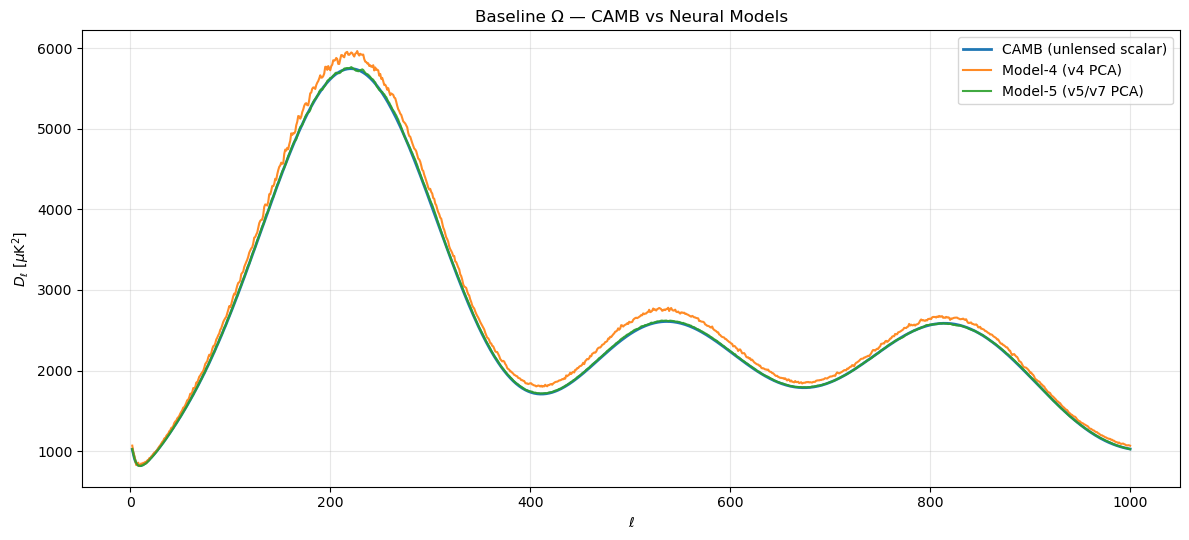

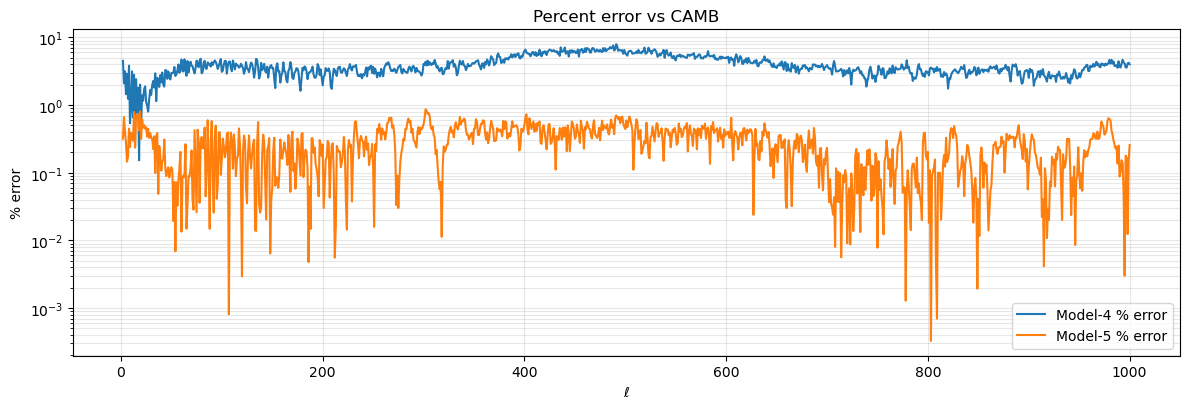

Model-4  →  mean: 3.93% | median: 3.65% | p95: 6.35% | max: 7.95%
Model-5  →  mean: 0.277% | median: 0.271% | p95: 0.581% | max: 0.867%


In [84]:
def compare_camb_vs_models(
    omega_b=None, omega_cdm=None, omega_g=None, omega_ur=None,
    show_errors=True, title_prefix="",
):
    # ── Prepare ℓ-range consistent with both PCA packs ────────────────────────────────
    L4 = int(pca_comp4[0].shape[1])   # [C, L]
    L5 = int(pca_comp5[0].shape[1])   # [C, L]
    L  = min(L4, L5)
    l_range = np.arange(2, 2 + L)     # 2..(L+1) inclusive → length L
    lmax_plot = int(l_range[-1])      # e.g. L=799 → lmax=800

    # ── Build CAMB params with optional overrides ─────────────────────────────────────
    camb_params = params.copy()
    if omega_b  is not None: camb_params["omega_b"]   = float(omega_b)
    if omega_cdm is not None: camb_params["omega_c"]  = float(omega_cdm)
    if omega_g  is not None: camb_params["omega_g"]   = float(omega_g)
    if omega_ur is not None: camb_params["omega_ur"]  = float(omega_ur)

    # ── Run CAMB (D_ℓ) ────────────────────────────────────────────────────────────────
    Dl_camb_full = camb_dl(camb_params, lmax=lmax_plot)   # length L
    Dl_camb = Dl_camb_full[:L]                            # align to L

    # ── Run models (D_ℓ) ─────────────────────────────────────────────────────────────
    D4 = get_D_ell_unified(
        model4, l_range,
        omega_b=omega_b, omega_cdm=omega_cdm, omega_g=omega_g, omega_ur=omega_ur,
        pca=pca_comp4, log_is_D_ell=True
    )
    D5 = get_D_ell_unified(
        model5, l_range,
        omega_b=omega_b, omega_cdm=omega_cdm, omega_g=omega_g, omega_ur=omega_ur,
        pca=pca_comp5, log_is_D_ell=True
    )

    # ── Plot D_ℓ ──────────────────────────────────────────────────────────────────────
    plt.figure(figsize=(12, 5.5))
    plt.plot(l_range, Dl_camb, label="CAMB (unlensed scalar)", linewidth=2)
    plt.plot(l_range, D4, label="Model-4 (v4 PCA)", alpha=0.9)
    plt.plot(l_range, D5, label="Model-5 (v5/v7 PCA)", alpha=0.9)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$D_\ell\ [\mu \mathrm{K}^2]$")
    ttl = "CAMB vs Neural Models"
    if title_prefix:
        ttl = f"{title_prefix} — {ttl}"
    plt.title(ttl)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ── Plot % error w.r.t. CAMB (optional) ───────────────────────────────────────────
    summaries = {}
    summaries["Model-4"] = percent_error_summary(Dl_camb, D4)
    summaries["Model-5"] = percent_error_summary(Dl_camb, D5)

    if show_errors:
        err4 = percent_error(Dl_camb, D4)
        err5 = percent_error(Dl_camb, D5)

        plt.figure(figsize=(12, 4.2))
        plt.semilogy(l_range, np.clip(err4, 1e-12, None), label="Model-4 % error")
        plt.semilogy(l_range, np.clip(err5, 1e-12, None), label="Model-5 % error")
        plt.xlabel(r"$\ell$")
        plt.ylabel("% error")
        plt.title("Percent error vs CAMB")
        plt.grid(True, which="both", alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ── Print compact summaries ───────────────────────────────────────────────────────
    for name, s in summaries.items():
        print(f"{name}  →  mean: {s['mean']:.3g}% | median: {s['median']:.3g}% | p95: {s['p95']:.3g}% | max: {s['max']:.3g}%")

    return {"l_range": l_range, "Dl_camb": Dl_camb, "D4": D4, "D5": D5, "summaries": summaries}


# ───────────────────────────────────────────────────────────────────────────────────────
# EXAMPLES (edit these Ω's as you like; None = use your defaults)
# ───────────────────────────────────────────────────────────────────────────────────────
# Example 1: Baseline (Planck-ish defaults)
_ = compare_camb_vs_models(
    omega_b=0.02237, omega_cdm=0.12000, omega_g=2.471e-5, omega_ur=1.71e-5,
    title_prefix="Baseline Ω"
)


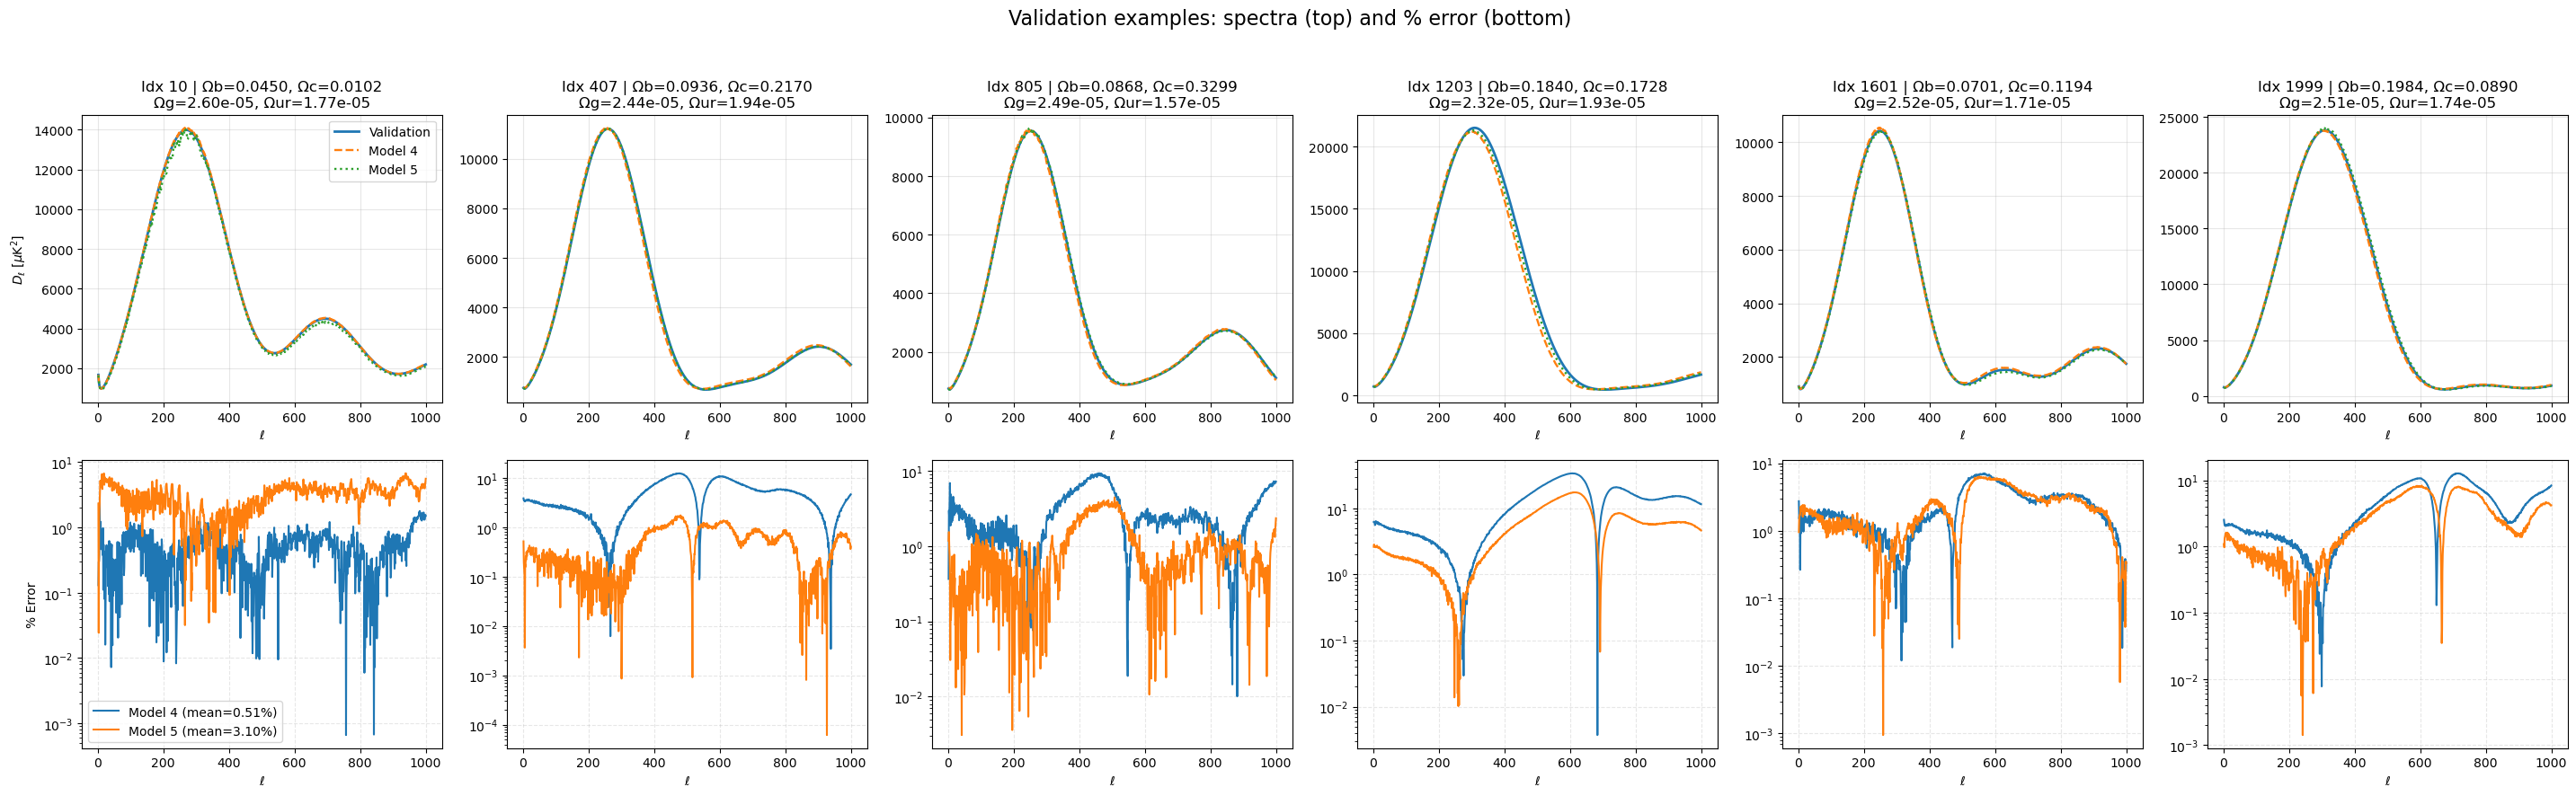

In [85]:
val_path = "final_model/dataset/val_2000_clean.h5"

def _read_first_present(f, keys):
    for k in keys:
        if k in f:
            return f[k][:]
            
    raise KeyError(f"None of {keys} found in file.")

# Load validation data (robust to naming)
with h5py.File(val_path, "r") as f:
    ob  = _read_first_present(f, ("omega_b",))
    oc  = _read_first_present(f, ("omega_cdm","omega_c"))
    og  = _read_first_present(f, ("omega_g",))
    our = _read_first_present(f, ("omega_ur",))
    X   = np.column_stack([ob, oc, og, our]).astype(np.float32)
    ell_val = _read_first_present(f, ("ell",)).astype(int)

    # spectra: try d_ell, then Dl, then Cl
    if "d_ell" in f:
        Y = f["d_ell"][:]
        # Heuristic: if it looks log-like, exponentiate
        Y_med = float(np.median(Y))
        D_true = np.exp(Y).astype(np.float32) if Y_med < 50.0 else Y.astype(np.float32)
    elif "Dl" in f:
        D_true = f["Dl"][:].astype(np.float32)
    elif "Cl" in f:
        Cl = f["Cl"][:].astype(np.float32)
        D_true = (ell_val*(ell_val+1)/(2*np.pi))[None,:] * Cl
    else:
        raise KeyError("No 'd_ell', 'Dl', or 'Cl' dataset found.")

# Choose 6 evenly spaced samples (or fewer if set is small)
N_show = min(6, len(X))
idxs = np.linspace(10, len(X)-1, N_show, dtype=int)

# Align to model basis length
L4 = pca_comp4[0].shape[1]
L5 = pca_comp5[0].shape[1]
Lval = D_true.shape[1]
L = min(L4, L5, Lval)
ell_use = ell_val[:L]
D_true  = D_true[:, :L]

# Predict with both models
Dl_m4 = []
Dl_m5 = []

for i in idxs:
    
    omega = dict(omega_b=X[i,0], omega_cdm=X[i,1], omega_g=X[i,2], omega_ur=X[i,3])
    Dl_m4.append(get_D_ell_unified(model4, ell_use, pca=pca_comp4, log_is_D_ell=True, **omega))
    Dl_m5.append(get_D_ell_unified(model5, ell_use, pca=pca_comp5, log_is_D_ell=True, **omega))

Dl_m4 = np.array(Dl_m4)
Dl_m5 = np.array(Dl_m5)

# Plot spectra (top row) and % error (bottom row) like your example
fig, axs = plt.subplots(2, N_show, figsize=(4.8*N_show, 9))

for k, i in enumerate(idxs):
    
    true_i = D_true[i]
    m4_i   = Dl_m4[k]
    m5_i   = Dl_m5[k]

    err4 = np.abs(true_i - m4_i) / np.clip(true_i, 1e-30, None) * 100.0
    err5 = np.abs(true_i - m5_i) / np.clip(true_i, 1e-30, None) * 100.0

    # spectra
    ax = axs[0, k]
    ax.plot(ell_use, true_i, label="Validation", lw=2)
    ax.plot(ell_use, m4_i,   label="Model 4", lw=1.7, ls="--")
    ax.plot(ell_use, m5_i,   label="Model 5", lw=1.7, ls=":")
    ax.set_title(
        f"Idx {i} | "
        f"Ωb={X[i,0]:.4f}, Ωc={X[i,1]:.4f}\n"
        f"Ωg={X[i,2]:.2e}, Ωur={X[i,3]:.2e}"
    )
    ax.set_xlabel(r"$\ell$")
    if k == 0:
        ax.set_ylabel(r"$D_\ell\ [\mu \mathrm{K}^2]$")
        ax.legend()
    ax.grid(alpha=0.3)

    # % error
    ax = axs[1, k]
    ax.plot(ell_use, err4, label=f"Model 4 (mean={err4.mean():.2f}%)")
    ax.plot(ell_use, err5, label=f"Model 5 (mean={err5.mean():.2f}%)")
    ax.set_yscale("log")
    ax.set_xlabel(r"$\ell$")
    if k == 0:
        ax.set_ylabel("% Error")
        ax.legend()
    ax.grid(alpha=0.3, ls="--")

plt.suptitle("Validation examples: spectra (top) and % error (bottom)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [86]:
val_path = "final_model/dataset/val_2000_clean.h5"

def _read_first_present(f, keys):
    for k in keys:
        if k in f:
            return f[k][:]
    raise KeyError(f"None of {keys} found in file.")

# --- Load validation set ---
with h5py.File(val_path, "r") as f:
    
    ob      = _read_first_present(f, ("omega_b",))
    oc      = _read_first_present(f, ("omega_cdm","omega_c"))
    og      = _read_first_present(f, ("omega_g",))
    our     = _read_first_present(f, ("omega_ur",))
    X       = np.column_stack([ob, oc, og, our]).astype(np.float32)
    ell_val = _read_first_present(f, ("ell",)).astype(int)

    if "d_ell" in f:
        Y = f["d_ell"][:]
        D_true = np.exp(Y).astype(np.float32) if float(np.median(Y)) < 50.0 else Y.astype(np.float32)
    elif "Dl" in f:
        D_true = f["Dl"][:].astype(np.float32)
    elif "Cl" in f:
        Cl = f["Cl"][:].astype(np.float32)
        D_true = (ell_val*(ell_val+1)/(2*np.pi))[None,:] * Cl
    else:
        raise KeyError("No 'd_ell', 'Dl', or 'Cl' dataset found.")

# --- Align to model ℓ-lengths ---
L4  = pca_comp4[0].shape[1]
L5  = pca_comp5[0].shape[1]
Lva = D_true.shape[1]
L   = min(L4, L5, Lva)
ell_use = ell_val[:L]
D_true  = D_true[:, :L]

# --- Batched prediction helpers (to keep memory sane) ---
def predict_batch(model, X, pca, batch_size=512, device="cpu"):
    import torch
    outs = []
    model.to(device).eval()
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.as_tensor(X[i:i+batch_size], dtype=torch.float32, device=device)
            logD = predict_log_spectrum_unified(model, xb, pca)   # [B, L]
            D    = torch.exp(torch.clamp(logD, -20, 20)).cpu().numpy()
            outs.append(D)
    return np.concatenate(outs, axis=0)

# --- Predict all ---
DEVICE = next(model4.parameters()).device
D4 = predict_batch(model4, X, pca_comp4,    batch_size=512, device=DEVICE)[:, :L]
D5 = predict_batch(model5, X, pca_comp5, batch_size=512, device=DEVICE)[:, :L]

# --- Metrics (per-sample mean % error) ---
denom = np.clip(D_true, 1e-30, None)
err4  = np.abs(D4 - D_true) / denom * 100.0
err5  = np.abs(D5 - D_true) / denom * 100.0

mean4 = err4.mean(axis=1);  max4 = err4.max(axis=1)
mean5 = err5.mean(axis=1);  max5 = err5.max(axis=1)

def summarize(name, mean_arr, max_arr):
    print(f"{name}:")
    print(f"  Mean % Error → avg={mean_arr.mean():.3f}, median={np.median(mean_arr):.3f}, p95={np.percentile(mean_arr,95):.3f}")
    print(f"  Max  % Error → avg={max_arr.mean():.3f},  median={np.median(max_arr):.3f},  p95={np.percentile(max_arr,95):.3f}")

print(f"=== Evaluation on full validation set: N={len(X)}, L={L} ===")
summarize("Model 4", mean4, max4)
summarize("Model 5", mean5, max5)


=== Evaluation on full validation set: N=2000, L=999 ===
Model 4:
  Mean % Error → avg=5.525, median=5.029, p95=12.611
  Max  % Error → avg=16.446,  median=14.119,  p95=37.812
Model 5:
  Mean % Error → avg=2.846, median=2.605, p95=6.338
  Max  % Error → avg=8.882,  median=7.669,  p95=20.480


In [11]:
# === Planck-like spectrum: CAMB vs CLASS vs Model-4 vs Model-5 (self-contained) ===
import numpy as np
import matplotlib.pyplot as plt
from classy import Class

# -- Planck-like densities (h=0.675) --
planck = dict(
    omega_b  = 0.02237,
    omega_cdm= 0.12000,
    omega_g  = OMEGA_G0,
    omega_ur = OMEGA_UR0,
)

params = {
    "omega_b" : planck["omega_b"],
    "omega_c" : planck["omega_cdm"],
    "omega_g" : planck["omega_g"],
    "omega_ur": planck["omega_ur"],
    "omega_k" : 0.0,
    "H0"      : 67.5,
    "YHe"     : 0.2471,
    "tau"     : 0.054,
    "As"      : 2.1e-9,
    "n_s"     : 0.965,
}

l_max = 1000
ell    = np.arange(2, l_max+1)

# -- CAMB truth (uses your training radiation mapping via camb_dl) --
Dl_camb_planck = np.asarray(camb_dl(params, l_max=l_max)).ravel()

# -- CLASS truth with the *same* mapping (T_CMB from omega_g, Neff from omega_ur) --
def Dl_from_CLASS_mapped(omegas, l_max=1000):
    ob, oc, og, our = omegas["omega_b"], omegas["omega_cdm"], omegas["omega_g"], omegas["omega_ur"]
    t_cmb = tcmb_omega_g(og)
    Neff  = neff_omega_ur(our, t_cmb)

    cls_in = {
        "output"        : "tCl",
        "l_max_scalars" : l_max,
        "lensing"       : "no",
        "omega_b"       : float(ob),
        "omega_cdm"     : float(oc),
        "T_cmb"         : float(t_cmb),
        "N_ur"          : float(Neff),
        "h"             : 0.675,      # H0 = 67.5
        "A_s"           : 2.1e-9,
        "n_s"           : 0.965,
        "tau_reio"      : 0.054,
        "YHe"           : 0.2471,
    }
    cosmo = Class(); cosmo.set(cls_in); cosmo.compute()
    clTT  = cosmo.raw_cl(l_max)["tt"]
    cosmo.struct_cleanup(); cosmo.empty()
    ell_c = np.arange(len(clTT))
    Dl    = (ell_c*(ell_c+1)/(2*np.pi)) * clTT * (t_cmb**2) * 1e12
    return Dl[2:l_max+1]

Dl_class_planck = np.asarray(Dl_from_CLASS_mapped(planck, l_max=l_max)).ravel()

# -- Model predictions (1D each; do NOT reuse Dl_m4/Dl_m5 from other cells) --
Dl_m4_planck = np.asarray(get_D_ell_unified(model4, ell, pca=pca_comp,    log_is_D_ell=True, **planck)).ravel()
Dl_m5_planck = np.asarray(get_D_ell_unified(model5, ell, pca=pca_comp_v5, log_is_D_ell=True, **planck)).ravel()

# -- Align lengths safely --
L = min(len(ell), len(Dl_camb_planck), len(Dl_class_planck), len(Dl_m4_planck), len(Dl_m5_planck))
ell_use         = ell[:L]
Dl_camb_planck  = Dl_camb_planck[:L]
Dl_class_planck = Dl_class_planck[:L]
Dl_m4_planck    = Dl_m4_planck[:L]
Dl_m5_planck    = Dl_m5_planck[:L]

# -- Error summaries vs CAMB --
def perc_summary(true, pred):
    e = np.abs(pred - true) / np.clip(true, 1e-30, None) * 100.0
    return np.mean(e), np.max(e)

m4_mean, m4_max = perc_summary(Dl_camb_planck, Dl_m4_planck)
m5_mean, m5_max = perc_summary(Dl_camb_planck, Dl_m5_planck)
cl_mean, cl_max = perc_summary(Dl_camb_planck, Dl_class_planck)

# -- Plot --
plt.figure(figsize=(12,6))
plt.plot(ell_use, Dl_camb_planck,  label="CAMB (mapped)", lw=2)
plt.plot(ell_use, Dl_class_planck, label=f"CLASS — mean%={cl_mean:.2f} max%={cl_max:.2f}", lw=1.8)
plt.plot(ell_use, Dl_m4_planck,    label=f"Model 4 — mean%={m4_mean:.2f} max%={m4_max:.2f}", lw=1.8, ls='--')
plt.plot(ell_use, Dl_m5_planck,    label=f"Model 5 — mean%={m5_mean:.2f} max%={m5_max:.2f}", lw=1.8, ls=':')
plt.xlabel(r"Multipole $\ell$")
plt.ylabel(r"$D_\ell\ [\mu \mathrm{K}^2]$")
plt.title("Planck-like spectrum: CAMB vs CLASS vs Models")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


NameError: name 'pca_comp' is not defined

In [169]:
import numpy as np, h5py

def pca_ceiling_at_planck(pca_path, l_max=1000):
    # truth with your mapping (same as training)
    planck_params = {
        "omega_b": 0.02237, "omega_c": 0.12000,
        "omega_g": OMEGA_G0, "omega_ur": OMEGA_UR0,
        "omega_k": 0.0, "H0": 67.5, "YHe": 0.2471,
        "tau": 0.054, "As": 2.1e-9, "n_s": 0.965
    }
    Dl_true = camb_dl(planck_params, l_max=l_max)             # [999]
    logD    = np.log(np.clip(Dl_true, 1e-30, None))

    with h5py.File(pca_path, "r") as f:
        B = f["basis"][:].astype(np.float64)                 # [C, L]
        M = f["mean_spectrum"][:].astype(np.float64)         # [L]

    # orthonormal rows → projection is (logD - M) ⋅ B^T
    alpha     = (logD - M) @ B.T                              # [C]
    logD_rec  = alpha @ B + M                                 # [L]
    Dl_rec    = np.exp(logD_rec)

    err = np.abs(Dl_rec - Dl_true) / np.clip(Dl_true, 1e-30, None) * 100
    print(f"PCA ceiling @ Planck: mean={err.mean():.2f}% | max={err.max():.2f}%")
    return err

_ = pca_ceiling_at_planck("model-5/dataset5/pca_merged_dataset_new.h5", l_max=1000)


PCA ceiling @ Planck: mean=0.06% | max=1.31%


## ---------------------------------------------------------------------

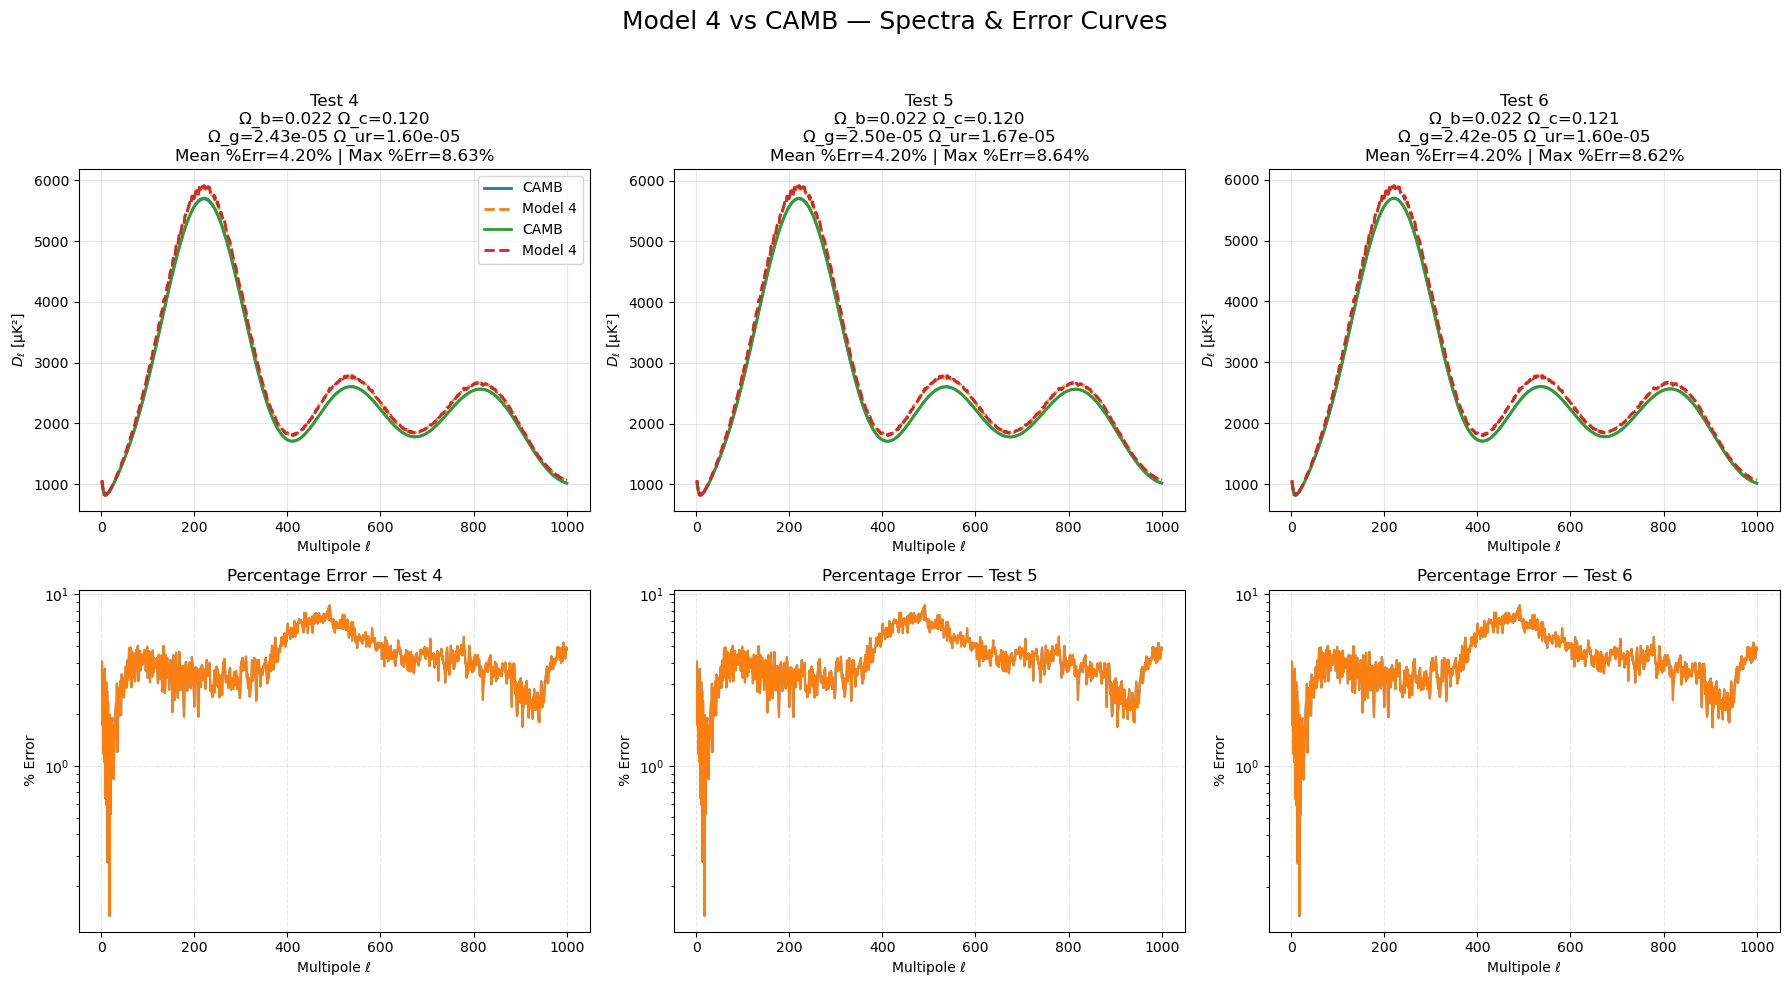

In [129]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import camb

# ----------------------------- CAMB + NN Spectrum Functions -----------------------------
def get_camb_spectrum(omega_b, omega_cdm, omega_g, omega_ur):
    omega_lambda = 0.675**2 - (omega_b + omega_cdm + omega_g + omega_ur)
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=omega_b, omch2=omega_cdm, omk=0,
                       TCMB=T_CMB, tau=0.054, mnu=0, standard_neutrino_neff=True)
    pars.InitPower.set_params(As=2.1e-9, ns=0.965)
    pars.set_for_lmax(998, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    Dl_camb = results.get_cmb_power_spectra(pars, CMB_unit='muK')['unlensed_scalar'][2:1001, 0]
    return Dl_camb

def get_nn_spectrum(model, omega_b, omega_cdm, omega_g, omega_ur, pca_comp):
    x = torch.tensor([[omega_b, omega_cdm, omega_g, omega_ur]], dtype=torch.float32)
    with torch.no_grad():
        logCl = (model(x) @ pca_comp[0] + pca_comp[1]).cpu().numpy().flatten()
    logCl = np.clip(logCl, -20, 20)
    return np.exp(logCl)

# ----------------------------- Generate Valid Random Test Cases -----------------------------
num_tests = 10
test_cases = []
h_squared = 0.675**2

while len(test_cases) < num_tests:
    test_params = {
        'omega_b': np.random.uniform(0.022, 0.0221),
        'omega_cdm': np.random.uniform(0.12, 0.121),
        'omega_g': np.random.uniform(2.5e-5, 2.4e-5),
        'omega_ur': np.random.uniform(1.6e-5, 1.7e-5),
    }

    omega_sum = sum(test_params.values())
    if omega_sum <= h_squared:
        test_cases.append(test_params)

# ----------------------------- Compute Spectra & Errors -----------------------------
ells = np.arange(2, 1001)
spectra_data = []
percentage_errors = []

for params in test_cases:
    dl_camb = get_camb_spectrum(**params)
    dl_nn = get_nn_spectrum(model4, **params, pca_comp=pca_comp)
    perc_error = np.abs(dl_camb - dl_nn) / dl_camb * 100

    spectra_data.append((dl_camb, dl_nn, params))
    percentage_errors.append(perc_error)

# ----------------------------- Plot Spectra & Error Curves (6 Tests) -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx in range(6):
    dl_camb, dl_nn, params = spectra_data[idx]
    perc_error = percentage_errors[idx]
    overall_perc_error = np.mean(perc_error)
    max_perc_error = np.max(perc_error)

    row = idx // 3
    col = idx % 3

    # --- Top Row: Spectra Comparison ---
    ax_spectra = axs[0, col]
    ax_spectra.plot(ells, dl_camb, label="CAMB", lw=2)
    ax_spectra.plot(ells, dl_nn, label="Model 4", lw=2, ls="--")
    ax_spectra.set_xlabel("Multipole ℓ")
    ax_spectra.set_ylabel(r"$D_\ell$ [μK²]")
    ax_spectra.set_title(
        f"Test {idx+1}\n"
        f"Ω_b={params['omega_b']:.3f} Ω_c={params['omega_cdm']:.3f}\n"
        f"Ω_g={params['omega_g']:.2e} Ω_ur={params['omega_ur']:.2e}\n"
        f"Mean %Err={overall_perc_error:.2f}% | Max %Err={max_perc_error:.2f}%"
    )
    ax_spectra.grid(True, alpha=0.3)
    if col == 0:
        ax_spectra.legend()

    # --- Bottom Row: Percentage Error ---
    ax_error = axs[1, col]
    ax_error.plot(ells, perc_error, lw=1.5)
    ax_error.set_xlabel("Multipole ℓ")
    ax_error.set_ylabel("% Error")
    ax_error.set_yscale("log")
    ax_error.set_title(f"Percentage Error — Test {idx+1}")
    ax_error.grid(True, alpha=0.3, ls='--')

plt.suptitle("Model 4 vs CAMB — Spectra & Error Curves", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/home/sysadm/cosmic_network/model-4/planck-like-awful.png")
plt.show()

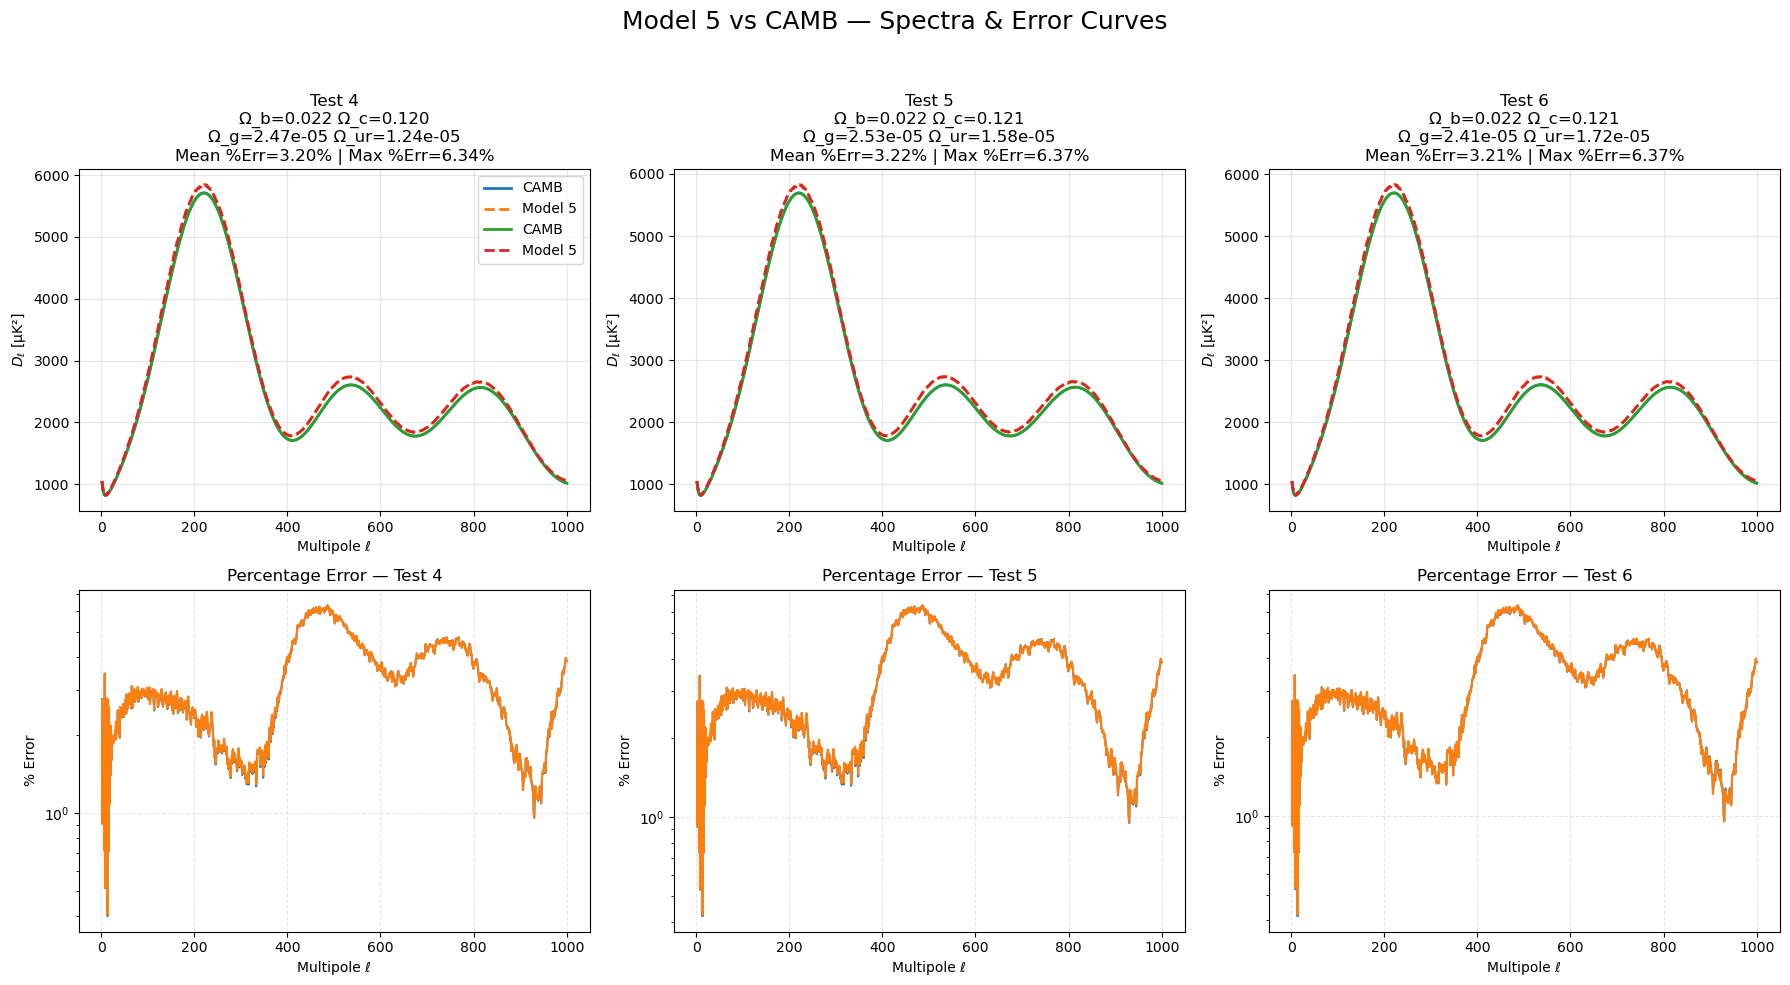

In [130]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import camb


# ----------------------------- Model-5 Spectrum -----------------------------
def get_nn_spectrum_v5(model, omega_b, omega_cdm, omega_g, omega_ur, pca_comp_v5):
    """
    model: trained model-5
    pca_comp_v5: [basis, mean, std] loaded via load_pca_components_v5
    """
    basis, mean, std = pca_comp_v5
    x = torch.tensor([[omega_b, omega_cdm, omega_g, omega_ur]], dtype=torch.float32)

    with torch.no_grad():
        coeffs_norm = model(x)  # standardized PCA coeffs
        logCl = (coeffs_norm * std) @ basis + mean
        logCl = logCl.cpu().numpy().flatten()

    logCl = np.clip(logCl, -20, 20)   # stability
    return np.exp(logCl)

# ----------------------------- Generate Valid Random Test Cases -----------------------------
num_tests = 10
test_cases = []
h_squared = 0.675**2

while len(test_cases) < num_tests:
    test_params = {
        'omega_b': np.random.uniform(0.022, 0.0221),
        'omega_cdm': np.random.uniform(0.12, 0.121),
        'omega_g': np.random.uniform(2.4e-5, 2.6e-5),
        'omega_ur': np.random.uniform(1.2e-5, 1.8e-5),
    }

    omega_sum = sum(test_params.values())
    if omega_sum <= h_squared:
        test_cases.append(test_params)

# ----------------------------- Compute Spectra & Errors -----------------------------
ells = np.arange(2, 1001)
spectra_data = []
percentage_errors = []

for params in test_cases:
    dl_camb = get_camb_spectrum(**params)
    dl_nn = get_nn_spectrum_v5(model5, **params, pca_comp_v5=pca_comp_v5)
    perc_error = np.abs(dl_camb - dl_nn) / dl_camb * 100

    spectra_data.append((dl_camb, dl_nn, params))
    percentage_errors.append(perc_error)

# ----------------------------- Plot Spectra & Error Curves (6 Tests) -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for idx in range(6):
    dl_camb, dl_nn, params = spectra_data[idx]
    perc_error = percentage_errors[idx]
    overall_perc_error = np.mean(perc_error)
    max_perc_error = np.max(perc_error)

    row = idx // 3
    col = idx % 3

    # --- Top Row: Spectra Comparison ---
    ax_spectra = axs[0, col]
    ax_spectra.plot(ells, dl_camb, label="CAMB", lw=2)
    ax_spectra.plot(ells, dl_nn, label="Model 5", lw=2, ls="--")
    ax_spectra.set_xlabel("Multipole ℓ")
    ax_spectra.set_ylabel(r"$D_\ell$ [μK²]")
    ax_spectra.set_title(
        f"Test {idx+1}\n"
        f"Ω_b={params['omega_b']:.3f} Ω_c={params['omega_cdm']:.3f}\n"
        f"Ω_g={params['omega_g']:.2e} Ω_ur={params['omega_ur']:.2e}\n"
        f"Mean %Err={overall_perc_error:.2f}% | Max %Err={max_perc_error:.2f}%"
    )
    ax_spectra.grid(True, alpha=0.3)
    if col == 0:
        ax_spectra.legend()

    # --- Bottom Row: Percentage Error ---
    ax_error = axs[1, col]
    ax_error.plot(ells, perc_error, lw=1.5)
    ax_error.set_xlabel("Multipole ℓ")
    ax_error.set_ylabel("% Error")
    ax_error.set_yscale("log")
    ax_error.set_title(f"Percentage Error — Test {idx+1}")
    ax_error.grid(True, alpha=0.3, ls='--')

plt.suptitle("Model 5 vs CAMB — Spectra & Error Curves", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/home/sysadm/cosmic_network/model-5/non-planck-like-v5.png")
plt.show()


In [135]:
import numpy as np
import torch
import camb
from tqdm import tqdm


# constants used in your dataset builder
T_CMB      = 2.7255
OMEGA_G0   = 2.369e-5   # photons (Planck-like)
OMEGA_UR0  = 1.680e-5   # massless neutrinos (Planck-like)

def tcmb_from_omega_g(omega_g):
    # T ∝ (Ω_γ)^{1/4}
    return T_CMB * (omega_g / OMEGA_G0)**0.25

def neff_from_omega_ur(omega_ur, t_cmb):
    # scale ∝ T^4
    scale = (t_cmb / T_CMB)**4
    return 3.046 * (omega_ur / (OMEGA_UR0 * scale))

def get_camb_spectrum_safe(omega_b, omega_cdm, omega_g, omega_ur, lmax=1000):
    """
    Return D_ell (ℓ=2..lmax) or None if CAMB fails.
    Uses the SAME radiation mapping as your training data.
    """
    try:
        t_cmb = tcmb_from_omega_g(omega_g)
        Neff  = neff_from_omega_ur(omega_ur, t_cmb)

        pars = camb.CAMBparams()
        pars.set_cosmology(H0=67.5,
                           ombh2=omega_b, omch2=omega_cdm, omk=0,
                           TCMB=t_cmb, tau=0.054, mnu=0)
        pars.Neff = float(Neff)
        pars.num_massive_neutrinos = 0

        pars.InitPower.set_params(As=2.1e-9, ns=0.965)
        pars.set_for_lmax(lmax, lens_potential_accuracy=0)

        results = camb.get_results(pars)
        Dl = results.get_cmb_power_spectra(pars, CMB_unit='muK')['unlensed_scalar'][:, 0]
        Dl = Dl[2:lmax+1]  # length = lmax-1
        if not np.all(np.isfinite(Dl)) or Dl.shape[0] != (lmax-1):
            return None
        return Dl
    except Exception:
        return None

# ----------------------------- Model-4 Spectrum (PCA: basis, mean) -----------------------------
def get_nn_spectrum_v4(model, omega_b, omega_cdm, omega_g, omega_ur, pca_comp):
    try:
        basis, mean = pca_comp
        x = torch.tensor([[omega_b, omega_cdm, omega_g, omega_ur]], dtype=torch.float32)
        with torch.no_grad():
            logCl = (model(x) @ torch.as_tensor(basis, dtype=torch.float32) +
                     torch.as_tensor(mean, dtype=torch.float32)).cpu().numpy().ravel()
        return np.exp(np.clip(logCl, -20, 20))
    except Exception:
        return None

# ----------------------------- Model-5 Spectrum (PCA: basis, mean, std) -----------------------------
def get_nn_spectrum_v5(model, omega_b, omega_cdm, omega_g, omega_ur, pca_comp_v5):
    try:
        basis, mean, std = pca_comp_v5
        x = torch.tensor([[omega_b, omega_cdm, omega_g, omega_ur]], dtype=torch.float32)
        with torch.no_grad():
            coeffs_std = model(x)
            logCl = (coeffs_std * torch.as_tensor(std, dtype=torch.float32)) @ \
                     torch.as_tensor(basis, dtype=torch.float32) + \
                     torch.as_tensor(mean, dtype=torch.float32)
            logCl = logCl.cpu().numpy().ravel()
        return np.exp(np.clip(logCl, -20, 20))
    except Exception:
        return None

# ----------------------------- Test-case generator with flatness -----------------------------
def generate_valid_case():
    """Sample a case satisfying flatness: ob+oc+og+our <= H^2."""
    omega_b   = np.random.uniform(0.01, 0.40)
    omega_cdm = np.random.uniform(0.01, 0.40)
    omega_g   = np.random.uniform(2.4e-5, 2.6e-5)
    omega_ur  = np.random.uniform(1.2e-5, 1.8e-5)
    if (omega_b + omega_cdm + omega_g + omega_ur) <= H2:
        return dict(omega_b=omega_b, omega_cdm=omega_cdm, omega_g=omega_g, omega_ur=omega_ur)
    return None

# ----------------------------- Comparison loop (with error handling) -----------------------------
def compare_models_robust(model4, pca_comp, model5, pca_comp_v5, target_runs=1000, lmax=1000, seed=123):
    rng = np.random.default_rng(seed)
    np.random.seed(seed)
    valid = 0
    attempts = 0

    mean_errs_v4, max_errs_v4 = [], []
    mean_errs_v5, max_errs_v5 = [], []

    pbar = tqdm(total=target_runs, desc="Comparing models (valid runs)")

    while valid < target_runs:
        attempts += 1

        case = None
        # try a few times to get a flat case
        for _ in range(10):
            case = generate_valid_case()
            if case is not None:
                break
        if case is None:
            continue

        Dl_camb = get_camb_spectrum_safe(**case, lmax=lmax)
        if Dl_camb is None:
            continue  # skip failed CAMB

        Dl_v4 = get_nn_spectrum_v4(model4, **case, pca_comp=pca_comp)
        Dl_v5 = get_nn_spectrum_v5(model5, **case, pca_comp_v5=pca_comp_v5)
        if Dl_v4 is None or Dl_v5 is None:
            continue

        # Avoid division by zero / negatives
        mask = (Dl_camb > 0) & np.isfinite(Dl_camb) & np.isfinite(Dl_v4) & np.isfinite(Dl_v5)
        if not np.any(mask):
            continue

        err_v4 = np.abs(Dl_camb[mask] - Dl_v4[mask]) / Dl_camb[mask] * 100.0
        err_v5 = np.abs(Dl_camb[mask] - Dl_v5[mask]) / Dl_camb[mask] * 100.0

        mean_errs_v4.append(err_v4.mean())
        max_errs_v4.append(err_v4.max())
        mean_errs_v5.append(err_v5.mean())
        max_errs_v5.append(err_v5.max())

        valid += 1
        pbar.update(1)

    pbar.close()

    def summ(name, mean_list, max_list):
        mean_arr = np.array(mean_list)
        max_arr  = np.array(max_list)
        print(f"{name}:")
        print(f"  Mean % Error  → avg={mean_arr.mean():.3f},  median={np.median(mean_arr):.3f},  p95={np.percentile(mean_arr,95):.3f}")
        print(f"  Max  % Error  → avg={max_arr.mean():.3f},   median={np.median(max_arr):.3f},   p95={np.percentile(max_arr,95):.3f}")
        return mean_arr, max_arr

    print(f"\n=== Model Comparison over {valid} valid CAMB runs (attempts={attempts}) ===")
    mean_v4, max_v4 = summ("Model 4", mean_errs_v4, max_errs_v4)
    mean_v5, max_v5 = summ("Model 5", mean_errs_v5, max_errs_v5)

    return {
        "mean_errs_v4": mean_v4, "max_errs_v4": max_v4,
        "mean_errs_v5": mean_v5, "max_errs_v5": max_v5
    }

# ----------------------------- Run -----------------------------
# Assumes you already have:
#   - model4, pca_comp   (basis, mean)
#   - model5, pca_comp_v5 (basis, mean, std)
results = compare_models_robust(model4, pca_comp, model5, pca_comp_v5, target_runs=1000, lmax=1000, seed=42)



Comparing models (valid runs): 100%|████████| 1000/1000 [08:51<00:00,  1.88it/s]


=== Model Comparison over 1000 valid CAMB runs (attempts=1000) ===
Model 4:
  Mean % Error  → avg=1.853,  median=1.626,  p95=4.203
  Max  % Error  → avg=6.022,   median=5.230,   p95=13.386
Model 5:
  Mean % Error  → avg=1.952,  median=1.727,  p95=4.321
  Max  % Error  → avg=7.137,   median=6.506,   p95=14.221


In [30]:
import gradio as gr
import numpy as np
import torch, matplotlib.cm as cm
from PIL import Image

# ─────────────────────────────────────────────────────────────
# constants & model
TCMB = 2.7255
H_SQUARED = 0.675**2          # ≈ 0.45625
N_MAP = 512

model4  = load_model(4,
    "model-4/hyper_weights_3/weights-sunny-sweep-22.pt",
    in_dim=4, out_dim=20, lay_dim=256, hid_lay=4)
pca_comp = load_pca_components(
    "model-4/dataset4/four_omega_merged_pca.h5")

rng = np.random.default_rng(42)
eps_fixed = (rng.normal(size=(N_MAP, N_MAP)) +
             1j * rng.normal(size=(N_MAP, N_MAP)))

# ─────────────────────────────────────────────────────────────
# fast flat-sky map (fixed phases)
def simulate_cmb_fixed(d_ell, ell, N=N_MAP, fov_deg=10):
    f_rad = np.deg2rad(fov_deg);  res = f_rad/N
    kx = np.fft.fftfreq(N, res);   ky = np.fft.fftfreq(N, res)
    ℓmap = 2*np.pi*np.hypot(*np.meshgrid(kx, ky)[::-1]);  ℓmap[ℓmap<2]=2
    Cℓ   = d_ell * 2*np.pi / (ell*(ell+1))
    Ck   = np.interp(ℓmap, ell, Cℓ)
    amp  = np.sqrt(Ck**1.5/2);  sky = np.fft.ifft2(amp*eps_fixed).real
    return sky

def predict_cmb(ω_b, ω_c, ω_g, ω_ur, ω_Λ):        # Ω_Λ only for display
    x = torch.tensor([[ω_b, ω_c, ω_g, ω_ur]], dtype=torch.float32)
    with torch.no_grad():
        logCl = (model4(x) @ pca_comp[0] + pca_comp[1]).cpu().numpy().ravel()
    ell = np.arange(2, 2+len(logCl));   d_ell = np.exp(np.clip(logCl, -20, 20))
    sky = simulate_cmb_fixed(d_ell, ell)
    μ, σ = sky.mean(), sky.std()
    norm = np.clip((sky-μ)/(2*σ), -1, 1);  norm = (norm+1)/2
    rgb = (cm.coolwarm(norm)[..., :3]*255).astype(np.uint8)
    return Image.fromarray(rgb)

# ─────────────────────────────────────────────────────────────
#  sum-enforcement helpers
def enforce_from_phys(ω_b, ω_c, ω_g, ω_ur):
    budget = H_SQUARED - (ω_b + ω_g + ω_ur)
    new_c  = min(ω_c, max(budget, 0.0))
    new_Λ  = max(budget - new_c, 0.0)
    return (gr.update(value=new_Λ, interactive=False),
            gr.update(value=new_c))

def enforce_from_lambda(ω_Λ, ω_b, ω_g, ω_ur):
    new_c = max(H_SQUARED - (ω_b + ω_g + ω_ur + ω_Λ), 0.0)
    return gr.update(value=new_c)

# ─────────────────────────────────────────────────────────────
# UI
with gr.Blocks(title="Flat-Sky CMB – Model 4 (ΣΩ ≤ h²)") as demo:
    gr.Markdown("### Live CMB map — fixed phases (ΣΩ constrained to h²)")

    with gr.Row():
        with gr.Column(scale=1):
            ω_b = gr.Slider(0.005, 0.040, 0.001, value=0.022,   label="Ω_b")
            ω_c = gr.Slider(0.001, 0.400, 0.001, value=0.120,   label="Ω_cdm")
            ω_g = gr.Slider(1e-5, 3e-5, 1e-6, value=2.469e-5, label="Ω_g")
            ω_ur= gr.Slider(1.5e-5, 1.7e-5, 1e-6, value=1.68e-5, label="Ω_ur")
            ω_Λ = gr.Slider(0.0, H_SQUARED, step=0.001,
                            value=H_SQUARED-(0.022+0.120+2.469e-5+1.68e-5),
                            label="Ω_Λ", interactive=False)
        with gr.Column(scale=2):
            out = gr.Image(label="CMB Map")

    # cheap enforcement while dragging
    for s in (ω_b, ω_c, ω_g, ω_ur):
        s.input(enforce_from_phys, [ω_b, ω_c, ω_g, ω_ur],
                [ω_Λ, ω_c], queue=False)
    ω_Λ.input(enforce_from_lambda, [ω_Λ, ω_b, ω_g, ω_ur],
              ω_c, queue=False)

    # heavy render only on release
    for s in (ω_b, ω_c, ω_g, ω_ur, ω_Λ):
        s.release(predict_cmb,
                  inputs=[ω_b, ω_c, ω_g, ω_ur, ω_Λ],
                  outputs=out, queue=False)

demo.launch()



* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
